## sklearn - scikit-learn, machine learning made easy

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

## General considerations

In the end, you want to apply your classifier on data that you have never seen before.
That means, your training-set should be representative of the whole population.
Generally, you do not really know the full specs of the whole population.

The easiest way is to just split your data into a train- and a test-set.
Split your data, such that you train your model (and select your parameters) on the train-set, and evaluate it on the (before unseen) test-set


In [7]:
iris = sns.load_dataset('iris')

# prepare train and test set, use 75% as train
iris['species_num'],labels = pd.factorize(iris.species)
iris['train'] = np.random.uniform(0,1,len(iris)) <= .75
train, test = iris[iris.train], iris[~iris.train]

# create index of columns to use as features
features = iris.columns[:4]

# convert string label (target) to number
X_train = train[features]
y_train = train.species_num

X_test = test[features]

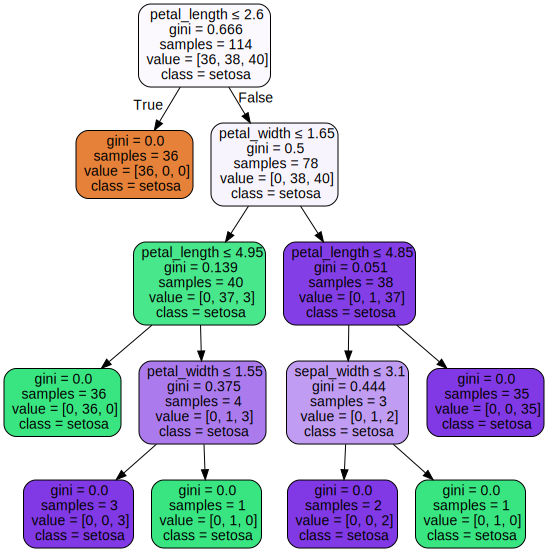

In [21]:
##### Train a decision tree classifier
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
# predict on test-set and evaluate
preds = clf.predict(X_test)
pd.crosstab(test.species, labels[preds], rownames=['Actual species'], colnames=['Predicted species'] )

import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.columns[:4],  
                         class_names=iris.species,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

## Support Vector Machine

* Maximizes margin of datapoints when computing separating hyperplane
* Multi-class: one-vs-one classification (train n_classes * (n_classes -1)/2 classifiers

<img src="./pictures/svm.jpg" />

* Kernel trick

<img src="./pictures/kerneltrick.png" />

[source] http://www.codecops.in/2015/11/using-svm-classifier.html
[source] http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r

In [9]:
##### Train a support vector machine
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
# predict on test-set and evaluate
preds = clf.predict(X_test)
pd.crosstab(test.species, labels[preds], rownames=['Actual species'], colnames=['Predicted species'] )

Predicted species  setosa  versicolor  virginica
Actual species                                  
setosa                 14           0          0
versicolor              0          12          0
virginica               0           0         10

## Random Forest

<img src="./pictures/rand-forest-1.jpg" />

[source] https://www.kdnuggets.com/2017/10/random-forests-explained.html

In [22]:
# train a RandomForestClassifier
clf = RandomForestClassifier(n_jobs=4, random_state=0)
clf.fit(X_train, y_train)
# predict on test-set and evaluate
preds = clf.predict(X_test)
pd.crosstab(test.species, labels[preds], rownames=['Actual species'], colnames=['Predicted species'] )

Predicted species  setosa  versicolor  virginica
Actual species                                  
setosa                 14           0          0
versicolor              0          11          1
virginica               0           0         10

### Model evaluation

Similar to the unified classifier-interface, sklearn offers a wide variety of algorithms and metrics
to evaluate your models (more at: http://scikit-learn.org/stable/modules/model_evaluation.html).
You can easily calculate and print most of the common metrics and scorings:

In [13]:
# evaluate metrics
from sklearn.metrics import accuracy_score
accuracy_score(test.species, labels[preds])

0.9444444444444444

In [15]:
from sklearn.metrics import classification_report
print(classification_report(test.species, labels[preds],))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        14
 versicolor       0.92      0.92      0.92        12
  virginica       0.90      0.90      0.90        10

avg / total       0.94      0.94      0.94        36



### Model evaluation/tuning
Now that we get a feeling of how the classifiers behave, how can we select the best classifier and its parameters based on the data we have?

Cross validation is like the train/test-split on steroids, it gives a statistically more significant estimate of the models generalization capabilities:

<img src="./pictures/K-fold_cross_validation_EN.jpg" />

[source] https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg

In [16]:
# cross validation - several train/test splits
from sklearn.model_selection import KFold, cross_val_score

k_fold = KFold(n_splits=3, shuffle=True)
cross_val_score(clf, iris[features], iris.species_num, cv=k_fold, n_jobs=-1)

array([0.96, 0.98, 0.94])

We can evaluate several models on the same k splits and decide which one performs best (the metric can also be selected).

Hyper-parameters of models can be tuned using one of the following methods:

More info here: http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

* GridSearchCV
* RandomizedSearchCV
* Hyperopt (https://github.com/hyperopt/hyperopt)

In [17]:
# grid search
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {"max_depth": [3,10,15],
              "max_features": [1, 2, 3],
              "min_samples_split": [2, 3, 10],}
gs = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3], 'min_samples_split': [2, 3, 10], 'max_depth': [3, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [18]:
gs.best_score_

0.9649122807017544

In [19]:
gs.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')